<a href="https://colab.research.google.com/github/dimitrivlachos/Proto-OS/blob/main/Facial_Expression_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we mount the drive and get the basic libraries necessary for machine learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

print("tf version:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tf version: 2.12.0


Next we load up our dataset. This data was gotten from kaggle:
https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset

Following https://www.tensorflow.org/tutorials/load_data/images

# Loading the Dataset

In [2]:
import pathlib

TRAIN_DIR = 'drive/MyDrive/FacialAnalysisData/train'
TEST_DIR = 'drive/MyDrive/FacialAnalysisData/test'

TRAIN_PATH = pathlib.Path(TRAIN_DIR)
TEST_PATH = pathlib.Path(TEST_DIR)

In [3]:
image_count = len(list(TRAIN_PATH.glob('*/*.jpg')))
image_count

28709

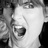

In [4]:
angry = list(TRAIN_PATH.glob('angry/*'))
PIL.Image.open(str(angry[0]))

Now we create a dataset

In [23]:
batch_size = 32
img_height = 48
img_width = 48

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


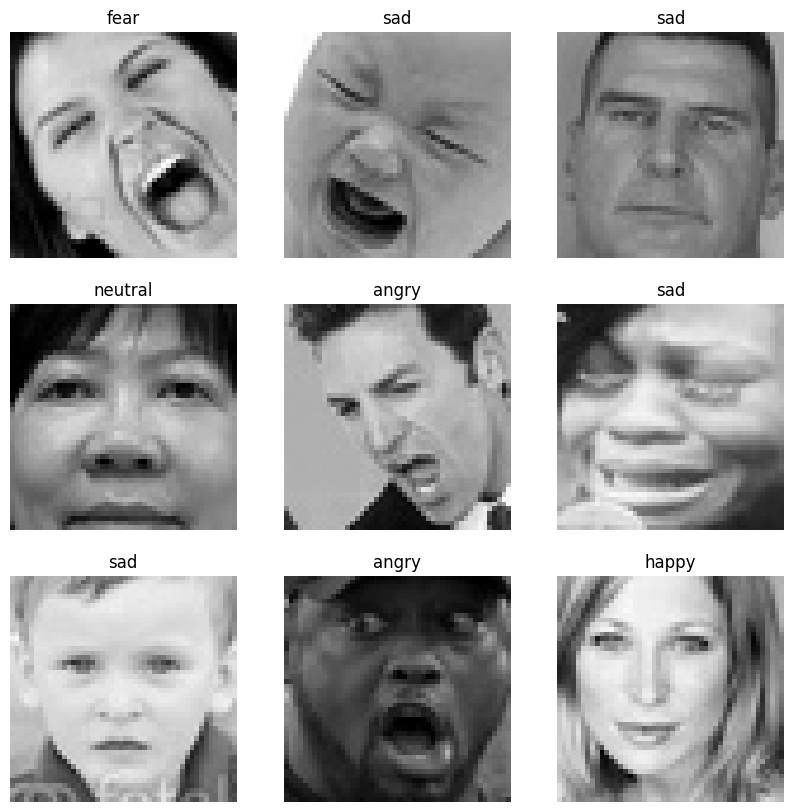

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


Next we will configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training initial model

With 7 classes, this small model will need to achieve an accuracy of ~14% in order to show statistical power

## Test 1 - Keras example model

In [13]:
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),                # This layer normalizes the RGB values
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
718/718 [==============================] - 228s 316ms/step - loss: 1.6606 - accuracy: 0.3390 - val_loss: 1.5156 - val_accuracy: 0.4231
Epoch 2/3
718/718 [==============================] - 9s 12ms/step - loss: 1.4491 - accuracy: 0.4408 - val_loss: 1.3935 - val_accuracy: 0.4602
Epoch 3/3
718/718 [==============================] - 9s 12ms/step - loss: 1.3368 - accuracy: 0.4870 - val_loss: 1.3361 - val_accuracy: 0.4905


Test 2 - Notebook from dataset model

In [19]:
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),                # This layer normalizes the RGB values
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
718/718 [==============================] - 89s 121ms/step - loss: 1.8128 - accuracy: 0.2537 - val_loss: 1.7381 - val_accuracy: 0.2790
Epoch 2/100
718/718 [==============================] - 88s 123ms/step - loss: 1.7099 - accuracy: 0.3055 - val_loss: 1.6253 - val_accuracy: 0.3466
Epoch 3/100
718/718 [==============================] - 88s 123ms/step - loss: 1.6231 - accuracy: 0.3567 - val_loss: 1.5457 - val_accuracy: 0.3912
Epoch 4/100
718/718 [==============================] - 88s 122ms/step - loss: 1.5715 - accuracy: 0.3863 - val_loss: 1.5289 - val_accuracy: 0.3928
Epoch 5/100
718/718 [==============================] - 87s 122ms/step - loss: 1.5234 - accuracy: 0.4088 - val_loss: 1.4365 - val_accuracy: 0.4471
Epoch 6/100
718/718 [==============================] - 88s 123ms/step - loss: 1.4813 - accuracy: 0.4268 - val_loss: 1.3873 - val_accuracy: 0.4673
Epoch 7/100
718/718 [==============================] - 88s 122ms/step - loss: 1.4430 - accuracy: 0.4404 - val_loss: 1.3577 -